# 이미지 식별 머신을 위한 데이터를 준비한다.

## 필요한 라이브러리를 불러 온다.

In [2]:
pip install torchvision

  Using cached torchvision-0.21.0-cp312-cp312-manylinux1_x86_64.whl.metadata (6.1 kB)
  Using cached torch-2.6.0-cp312-cp312-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached torchvision-0.21.0-cp312-cp312-manylinux1_x86_64.whl (7.2 MB)
Using cached torch-2.6.0-cp312-cp312-manylinux1_x86_64.whl (766.6 MB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cpu
    Uninstalling torch-2.5.1+cpu:
      Successfully uninstalled torch-2.5.1+cpu
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.3.1

In [3]:
!pip install torch


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
# 데이터 플로팅 라이브러리
import matplotlib.pyplot as plt
# 숫자 처리 라이브러리
import numpy as np
# 딥러닝을 위한 파이토치 라이브러리
import torch
from torch import nn, optim
# 토치비전 라이브러리
import torchvision
from torchvision import datasets, transforms, models
# 이미지 처리 라이브러리 (PIL, pillow)
from PIL import Image
# 주피터 노트북에서 plot이 보이도록 설정
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 데이터 디렉토리, 분할 비율, 변환 방법을 설정한다.

In [5]:
# 이미지 데이터가 있는 디렉토리와 데이터 세트 분할 비율(valid_size)을 정한다.
data_dir = './data'
valid_size = 0.2

# 이미지 데이터를 ResNet50에서 다룰 수 있도록 변환시키는 방법을 정한다. (t_transforms)
t_transforms = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.Resize(224),
                transforms.ToTensor()
])
# convert image size to 224x224 for ResNet50 after crop


### (확인) 변환 방법을 출력하여 확인해 본다.

In [6]:
# 설정한 이미지 데이터 변환 방법을 출력하여 확인한다.
print(t_transforms)

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


## 데이터를 로딩 함수를 작성한다.

### (연습) trainloader와 testloader를 만들어 본다.

#### 1. 학습 데이터 세트 및 테스트 데이터 세트의 디렉토리 및 변환 방식을 지정한다.

In [7]:
# datasets.ImageFolder를 사용해서 학습 데이터(train_data)와 테스트 데이터(test_data)를 만든다.
# make train_data and test_data using datasets.ImageFolder
train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
test_data = datasets.ImageFolder(data_dir, transform=t_transforms)

# 학습 데이터의 형식을 확인한다.
print(train_data)

# 학습 데이터와 테스트 데이터의 길이를 확인한다. 아직 분할 전이므로 둘 다 155개로 동일함.
print(len(train_data), len(test_data))



Dataset ImageFolder
    Number of datapoints: 155
    Root location: ./data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
155 155


#### 2. 데이터세트를 섞기 위해, 우선 인덱스를 만들어 랜덤하게 섞는다.

In [8]:
# train_data 사이즈만큼의 정수값을 갖는 인덱스 리스트(indices)를 만들고 확인한다.
num_train = len(train_data)
indices = list(range(num_train))
print(indices)

# 인덱스 리스트를 랜덤하게 섞고 확인한다.
np.random.shuffle(indices)
print(indices)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
[131, 63, 97, 106, 104, 51, 35, 135, 61, 87, 122, 149, 6, 153, 55, 9, 95, 68, 128, 66, 7, 130, 18, 142, 47, 70, 15, 80, 4, 133, 21, 102, 19, 64, 86, 79, 50, 20, 12, 72, 81, 82, 141, 101, 54, 73, 58, 41, 32, 125, 17, 90, 34, 25, 94, 154, 89, 111, 13, 24, 150, 136, 134, 110, 85, 83, 109, 14, 121, 5, 145, 117, 105, 118, 99, 46, 52, 30,

#### 3. 분할 비율(valid_size)에 따른 지점의 인덱스 값(split)을 계산한다.

In [9]:
# 분할 비율(valid_size=0.2)에 해당하는 인덱스를 계산하고 확인해 본다.
split = int(np.floor(num_train*valid_size))
print(split)

31


#### 4. split을 기준으로 학습 데이터 인덱스 리스트와 테스트 인덱스 리스트로 나눈다.

In [10]:
# 학습 데이터 인덱스 리스트 및 테스트 인덱스 리스트를 만들고 확인해 본다.
train_idx, test_idx = indices[split:], indices[:split]

print(train_idx)
print(test_idx)


[102, 19, 64, 86, 79, 50, 20, 12, 72, 81, 82, 141, 101, 54, 73, 58, 41, 32, 125, 17, 90, 34, 25, 94, 154, 89, 111, 13, 24, 150, 136, 134, 110, 85, 83, 109, 14, 121, 5, 145, 117, 105, 118, 99, 46, 52, 30, 120, 53, 67, 75, 65, 59, 38, 11, 124, 33, 76, 44, 139, 137, 16, 27, 36, 31, 93, 91, 113, 37, 78, 62, 144, 10, 148, 42, 43, 147, 8, 143, 57, 69, 22, 49, 126, 26, 88, 56, 116, 23, 45, 115, 127, 146, 77, 84, 48, 100, 114, 71, 28, 3, 129, 0, 112, 132, 40, 1, 60, 2, 123, 74, 152, 96, 108, 103, 29, 92, 39, 140, 151, 119, 98, 107, 138]
[131, 63, 97, 106, 104, 51, 35, 135, 61, 87, 122, 149, 6, 153, 55, 9, 95, 68, 128, 66, 7, 130, 18, 142, 47, 70, 15, 80, 4, 133, 21]


#### 5. 데이터 세트들의 샘플러 및 로더를 만들고 확인한다.

In [11]:
# 데이터 샘플링 방식(SubsetRandomSampler)을 지정한다
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# 데이터 로딩을 위한 loader를 만든다. (sampler, 배치 사이즈 등 지정)
trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

# 학습 loader와 테스트 loader의 class들을 출력하여 확인한다.
print(trainloader.dataset.classes)
print(trainloader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


### 코드들을 묶어서 load_split_train_test() 함수를 만든다.

In [12]:
# 위의 코드들을 묶어서 load_split_train_test() 함수를 만든다. (입력 : 데이터 디렉토리, 분할 비율) (출력 : 학습 데이터 로더, 테스트 데이터 로더)

def load_split_train_test(data_dir, valid_size):
    t_transforms = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.Resize(224),
                transforms.ToTensor()
    ])  

    train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))

    np.random.shuffle(indices)
    split = int(np.floor(num_train*valid_size))
    # 학습 데이터 인덱스 리스트 및 테스트 인덱스 리스트를 만들고 확인해 본다.
    train_idx, test_idx = indices[split:], indices[:split]

    from torch.utils.data.sampler import SubsetRandomSampler
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

    return trainloader, testloader    

### load_split_train_test() 함수를 이용하여 trainloader, testloader를 생성한다.

In [13]:
# load_split_train_test() 함수를 이용하여 trainloader와 testloader를 만들고 확인한다.
trainloader, testloader = load_split_train_test(data_dir, 0.2)

print(trainloader.dataset.classes)
print(testloader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


## 이미지 데이터 샘플들을 살펴본다.

### 임의의 데이터를 로딩한 후 이미지와 레이블을 반환하는 get_random_images() 함수를 만든다.

In [14]:
def get_random_images(num):

    data = datasets.ImageFolder(data_dir, transform=t_transforms)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]

    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)

    dataiter = iter(loader)
    images, labels = next(dataiter)

    return images, labels

### 임의 선택한 이미지를 표시해 본다.

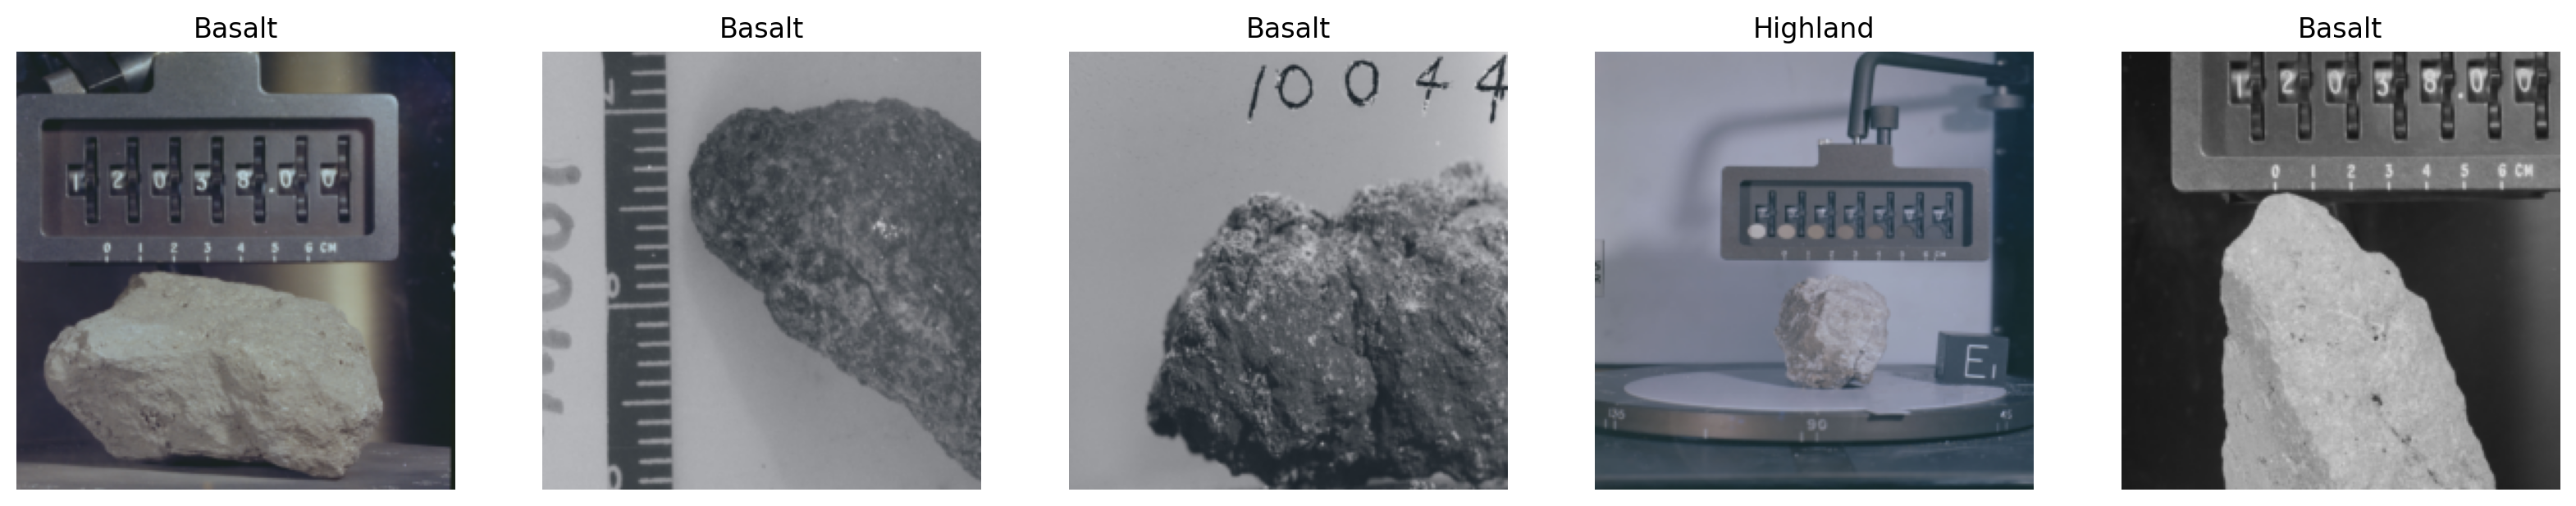

In [15]:
# 5개의 이미지와 레이블을 랜덤하게 가져온다.
images, labels = get_random_images(5)
# 픽셀 배열을 PIL 형식의 이미지로 변환하고 이미지 크기를 지정한다.
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20,20))

# 학습 데이터의 class 리스트를 얻는다.
classes = trainloader.dataset.classes

# 이미지를 표시하기 위한 설정을 한다.
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images),ii+1)
    index = labels[ii].item()
    sub.set_title(classes[index])
    plt.axis('off')
    plt.imshow(image)

# 주피터 노트북에 이미지를 표시한다.
plt.show()


# ResNet50 모델을 가져와 FCL(Fully Connected Layer)을 수정한다.

## Compute device를 정한다(CPU or GPU)

In [16]:
# compute device를 정하고 확인한다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## 사전학습된 ResNet50 모델을 지정한다.

In [24]:
# resnet50 모델을 pretrained=True로 설정한다.
model = models.resnet50(pretrained=True)


/usr/local/python/3.12.1/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/codespace/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


### (확인) 수정 전의 ResNet50 모델을 확인해 본다. 

## FCL을 수정한다.(뉴런 구축, 신경망 연결, FCL의 layer 설정 등)

In [27]:
# 모든 신경망 구축 : 전이학습을 위해 모델의 가중치를 freeze 한다.
for param in model.parameters():
    param.requires_grad = False
# 뉴런들을 연결하여 신경망을 생성한다.
model.fc = nn.Sequential(nn.Linear(2048, 512),
                        nn.ReLU(), nn.Dropout(0.2), nn.Linear(512,2), nn.LogSoftmax(dim=1))
                        # q: explain the above code
                        # a: 2048개의 입력을 받아 512개의 출력을 내고, ReLU 함수를 거쳐 0.2의 확률로 Dropout을 적용한다.
                        # 512개의 입력을 받아 2개의 출력을 내고, LogSoftmax 함수를 거쳐 1차원으로 변환한다.
                        # 1차원으로 변환된 출력을 갖는 신경망을 생성한다.

# 손실함수를 Cross entropy loss 함수로 지정한다.
citerion = nn.NLLLoss()

# optimizer를 Adam으로 지정한다.
optimizer = optim.Adam(model.fc.parameters(),lr=0.003)

# 신경망을 compute device로 보낸다.
model.to(device)
# 종료 여부를 출력한다.
print('done!')


done!


### (확인) FCL을 확인해 본다.

In [28]:
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
  (4): LogSoftmax(dim=1)
)


# 모델의 FCL을 학습시키고 테스트 한다.

## 모델 학습/검증을 위한 변수를 설정한다.

In [29]:
# 에폭 및 출력 간격을 설정한다.
epochs = 10
print_every = 5
# 손실 변수들을 초기화 한다.
running_loss = 0
train_losses, test_losses = [],[]
# 현재의 학습 단계를 표현하는 steps 변수를 0으로 초기화 한다.
steps = 0


## 설정한 에폭만큼 모델을 학습시키며 검증/평가 한다.

In [ ]:
# 설정한 회수만큼 학습 후 테스트 및 평가해 본다.



### (확인) 학습 손실값과 테스트 손실값을 그래프로 확인한다.

In [21]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# in this graph, what is x-axis? y-axis?
# x-axis: epoch
# y-axis: loss

# 학습/테스트 완료된 모델을 저장한다.

In [22]:
# 추후 로드하여 사용할 수 있도록 학습/테스트 완료된 모델을 저장한다.


# 완성된 모델을 사용하여 예측한다.

## 저장한 모델을 불러온다.

In [23]:
# 저장한 모델을 불러온다.


### (확인) 불러온 모델을 확인해 본다.

## 이미지 예측을 위해 predict_image() 함수를 만든다.

## 5개의 이미지를 임의로 가져와 예측해 본다.